In [20]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family']='serif'

from tqdm.auto import tqdm

In [10]:
log_paths = [
    "batch_50/log_hist.pkl",
    "batch_100/log_hist.pkl",
    "batch_150/log_hist.pkl",
]

logs = []

for path in log_paths:
    with open(path, 'rb') as file:
        logs.append(pickle.load(file))

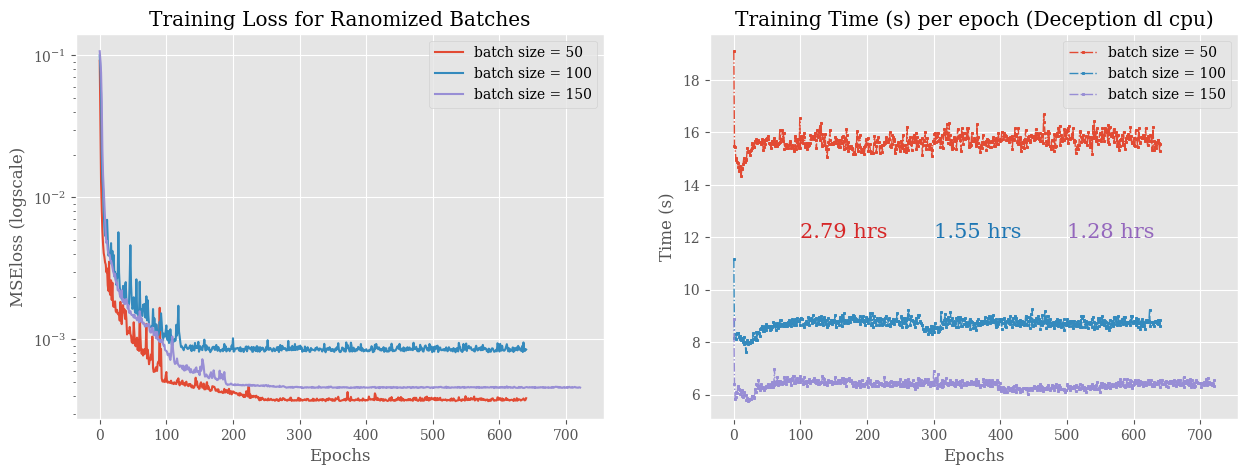

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

batch_sizes = [50, 100, 150]
for idx, log in enumerate(logs):
    lab = f"batch size = {batch_sizes[idx]}"
    ax1.plot(log["losses"], label = lab )
    ax1.set_yscale("log")
    ax1.set_title("Training Loss for Ranomized Batches")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSEloss (logscale)")
    ax1.legend()

    tot_time = np.sum(log['times'])
    x_text = [100, 300, 500]
    text_colors = ["tab:red", "tab:blue", "tab:purple"]
    ax2.text(x_text[idx],12, f"{tot_time / (60*60):.2f} hrs", c=text_colors[idx],size=15)
    # print(tot_time / (60*60))
    ax2.plot(
        np.arange(len(log['times'])), log['times'],
        linestyle='-.', lw=1,          
        marker='+', markersize=1, markeredgewidth=2,  
        label=lab
    )
    ax2.set_title("Training Time (s) per epoch (Deception dl cpu)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Time (s)")
    ax2.legend()


plt.show()

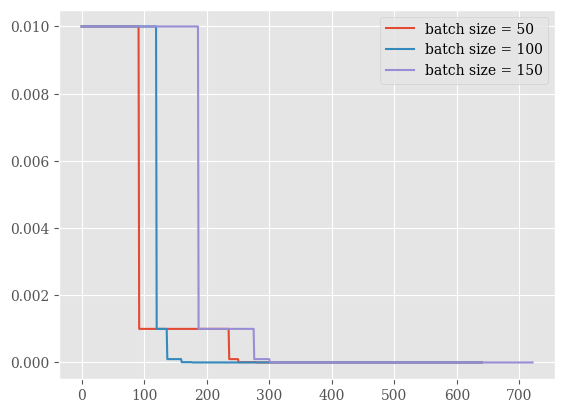

In [14]:
for idx, log in enumerate(logs):
    lab = f"batch size = {batch_sizes[idx]}"
    plt.plot(log['lr_hist'],label=lab)

plt.legend()
plt.show()

## Phase portraits

In [15]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLP, StabNODE
import torch
device = 'cpu'

### load model

In [16]:
model_path = "batch_50/model_opt_states.pt"

In [17]:
f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=0, upper_bound=1)
model = StabNODE(f,g).to(device)

In [18]:
config = torch.load(model_path, map_location=device, weights_only=False)
f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])

<All keys matched successfully>

## Chat chat bifurcation 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from numpy.linalg import eigvals
from scipy.integrate import solve_ivp

# -------------------------
# Your system parameters
gamma = 50
eps = 0.02
q1, q2 = 0.08, 0.04
b1 = 1 - eps
b2 = 1 - eps

def sigmoid(x):
    return 1 / (1 + np.exp(-gamma * x))

def c1_in(x):
    return q1 * (1 - sigmoid(x - b1))

def c2_in(y):
    return q1 * (1 - sigmoid(y - b2))

def c1_out(y):
    return q2 * (1 - sigmoid(y - b2))

def c2_out(y):
    return q2

def two_tank_system(t, x, u):
    x1, x2 = x
    p, v = u
    x1 = np.maximum(x1, 0)
    x2 = np.maximum(x2, 0)
    dx1dt = c1_in(x1)*(1 - v)*p - c1_out(x2)*np.sqrt(x1)
    dx2dt = c2_in(x2)*v*p + c1_out(x2)*np.sqrt(x1) - q2*np.sqrt(x2)
    return np.array([dx1dt, dx2dt])

# -------------------------
# Jacobian (analytical)
def jacobian(X, u):
    x1, x2 = X
    p, v = u
    x1m = max(x1, eps)
    x2m = max(x2, eps)

    s1 = sigmoid(x1m - b1)
    s2 = sigmoid(x2m - b2)
    ds1 = gamma * s1 * (1 - s1)
    ds2 = gamma * s2 * (1 - s2)

    c1out = q2 * (1 - s2)

    # derivatives
    dc1in_dx1 = -q1 * ds1
    dc2in_dx2 = -q1 * ds2
    dc1out_dx2 = -q2 * ds2

    df1_dx1 = dc1in_dx1 * (1 - v) * p - c1out * (1/(2*np.sqrt(x1m)))
    df1_dx2 = -dc1out_dx2 * np.sqrt(x1m)
    df2_dx1 = c1out * (1/(2*np.sqrt(x1m)))
    df2_dx2 = dc2in_dx2 * v * p + dc1out_dx2 * np.sqrt(x1m) - q2 * (1/(2*np.sqrt(x2m)))

    return np.array([[df1_dx1, df1_dx2],
                     [df2_dx1, df2_dx2]])


In [53]:

# -------------------------
# Continuation over v
p_fixed = 1.0
v_vals = np.linspace(0, 1, 501)
eqs = np.zeros((len(v_vals), 2))
stability = np.zeros(len(v_vals), dtype=bool)

x0 = np.array([0.1, 0.1])  # initial guess

for i, v in enumerate(v_vals):
    sol = root(lambda X: two_tank_system(0, X, (p_fixed, v)), x0, tol=1e-8)
    if not sol.success:
        # fallback guesses
        tries = [np.array([0.01,0.01]), np.array([1,1]), np.array([0.5,0.1])]
        for g in tries:
            sol = root(lambda X: two_tank_system(0, X, (p_fixed, v)), g, tol=1e-8)
            if sol.success:
                break
    if not sol.success:
        eqs[i,:] = np.nan
        stability[i] = False
        continue
    x_eq = sol.x
    eqs[i,:] = x_eq
    J = jacobian(x_eq, (p_fixed, v))
    eigs = eigvals(J)
    stability[i] = np.all(np.real(eigs) < 0)
    x0 = x_eq  # next initial guess


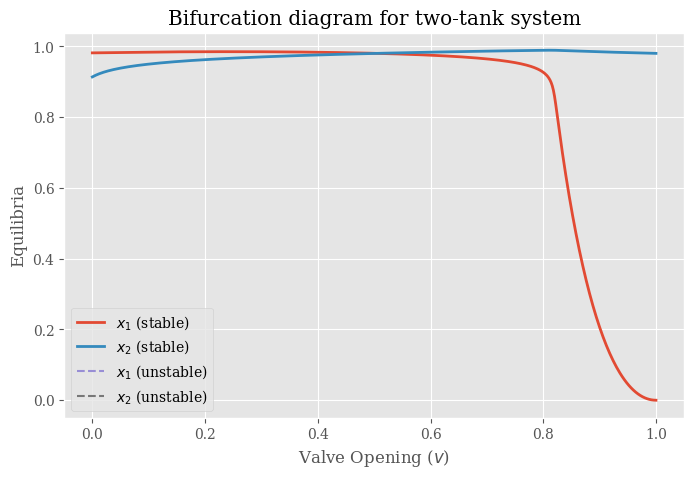

In [57]:

# -------------------------
# Plot bifurcation diagram
plt.figure(figsize=(8,5))
stable_mask = stability
unstable_mask = ~stability

plt.plot(v_vals[stable_mask], eqs[stable_mask,0], '-', lw=2, label=r'$x_1$ (stable)')
plt.plot(v_vals[stable_mask], eqs[stable_mask,1], '-', lw=2, label=r'$x_2$ (stable)')
plt.plot(v_vals[unstable_mask], eqs[unstable_mask,0], '--', lw=1.5, label=r'$x_1$ (unstable)')
plt.plot(v_vals[unstable_mask], eqs[unstable_mask,1], '--', lw=1.5, label=r'$x_2$ (unstable)')

plt.xlabel(r'Valve Opening ($v$)')
plt.ylabel('Equilibria')
plt.title('Bifurcation diagram for two-tank system')
plt.legend()
plt.grid(True)
plt.show()


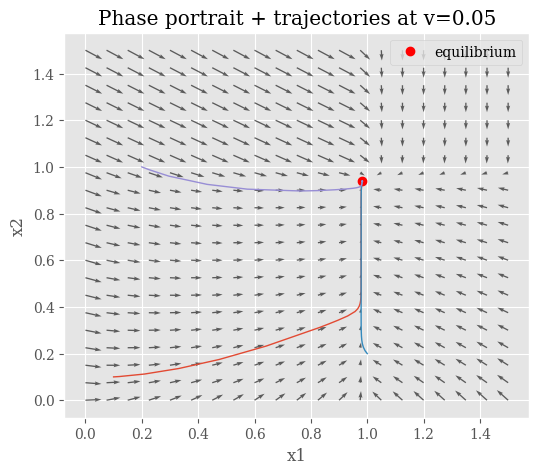

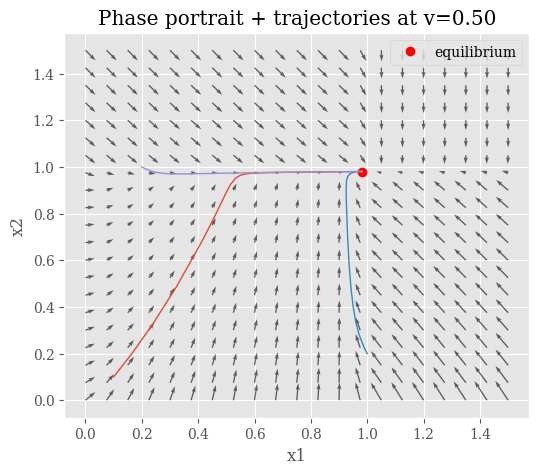

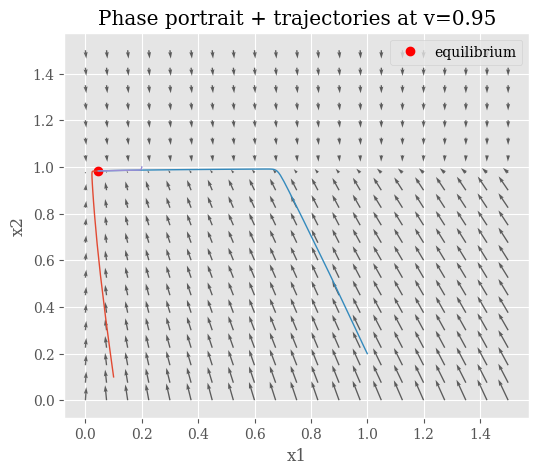

In [55]:

# -------------------------
# Optional: phase portrait + trajectories at selected v
selected_v = [0.05, 0.5, 0.95]
t_span = (0, 200)
for v in selected_v:
    x1_range = np.linspace(0, max(1.5, np.nanmax(eqs[:,0])*1.2), 21)
    x2_range = np.linspace(0, max(1.5, np.nanmax(eqs[:,1])*1.2), 21)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    U = np.zeros_like(X1)
    Vv = np.zeros_like(X2)

    for ii in range(X1.size):
        Xpt = np.array([X1.flat[ii], X2.flat[ii]])
        fp = two_tank_system(0, Xpt, (p_fixed, v))
        U.flat[ii] = fp[0]
        Vv.flat[ii] = fp[1]

    plt.figure(figsize=(6,5))
    plt.quiver(X1, X2, U, Vv, angles='xy', alpha=0.6)
    try:
        sol = root(lambda X: two_tank_system(0, X, (p_fixed, v)), eqs[np.argmin(np.abs(v_vals - v))])
        plt.plot(sol.x[0], sol.x[1], 'ro', label='equilibrium')
    except:
        pass

    for xinit in [[0.1,0.1],[1.0,0.2],[0.2,1.0]]:
        sol_ivp = solve_ivp(lambda t,y: two_tank_system(t, y, (p_fixed, v)), t_span, xinit, rtol=1e-6, atol=1e-9)
        plt.plot(sol_ivp.y[0], sol_ivp.y[1], '-', lw=1)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Phase portrait + trajectories at v={v:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [31]:
selected_v = [0.05, 0.5, 0.95]
t_span = (0, 200)
for v in selected_v:
    x1_range = np.linspace(0, max(1.5, np.nanmax(eqs[:,0])*1.2), 21)
    x2_range = np.linspace(0, max(1.5, np.nanmax(eqs[:,1])*1.2), 21)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    U = np.zeros_like(X1)
    Vv = np.zeros_like(X2)

    for ii in range(X1.size):
        Xpt = np.array([X1.flat[ii], X2.flat[ii]])
        fp = two_tank_system(0, Xpt, (p_fixed, v))
        U.flat[ii] = fp[0]
        Vv.flat[ii] = fp[1]

    plt.figure(figsize=(6,5))
    plt.quiver(X1, X2, U, Vv, angles='xy', alpha=0.6)
    try:
        sol = root(lambda X: two_tank_system(0, X, (p_fixed, v)), eqs[np.argmin(np.abs(v_vals - v))])
        plt.plot(sol.x[0], sol.x[1], 'ro', label='equilibrium')
    except:
        pass

    for xinit in [[0.1,0.1],[1.0,0.2],[0.2,1.0]]:
        sol_ivp = solve_ivp(lambda t,y: two_tank_system(t, y, (p_fixed, v)), t_span, xinit, rtol=1e-6, atol=1e-9)
        plt.plot(sol_ivp.y[0], sol_ivp.y[1], '-', lw=1)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Phase portrait + trajectories at v={v:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'eqs' is not defined

## Phase Portrait

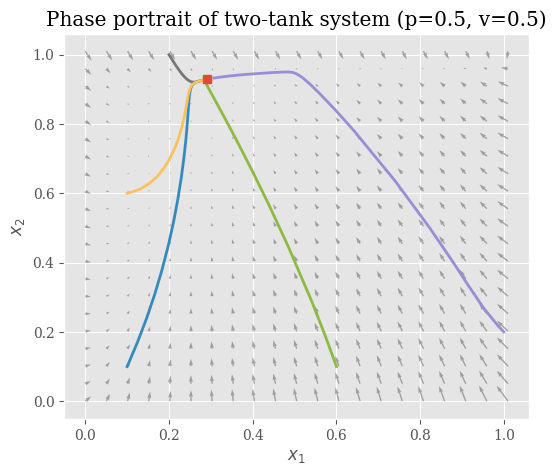

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
pi = .5
vi = 0.5

p_vals = np.linspace(0,1,5)
v_vals = np.linspace(0,1,5)

x_inits = [[0.1,0.1],[1.0,0.2],[0.2,1.0],[0.1,0.6],[0.6,0.1]]

n_points = 21
eps = 1e-2

x1_lin = np.linspace(0, 1+eps, n_points)
x2_lin = np.linspace(0, 1+eps, n_points)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

prev_eq = np.array([0.5,0.5])

t_span = (0, 200)



# IN LOOP
# Compute vector field
U = np.zeros_like(X1)
V = np.zeros_like(X2)

for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = np.array([X1[i,j], X2[i,j]])
        dxdt = two_tank_system(0, x, (pi, vi))
        U[i,j] = dxdt[0]
        V[i,j] = dxdt[1]

# speed  = np.sqrt(U**2+V**2)

# U = U/speed
# V = V/speed

# Plot phase portrait
plt.figure(figsize=(6,5))
plt.quiver(X1, X2, U, V, angles='xy', scale=1.7, color='grey', alpha=0.7)
# plt.streamplot(X1, X2, U, V, density=1.5, linewidth=1, arrowsize=1., color='grey')


try:
    sol = root(lambda X: two_tank_system(0, X, (pi, vi)), prev_eq)
    prev_eq = sol.x if sol.success else prev_eq
    plt.plot(sol.x[0], sol.x[1], label='equilibrium',zorder=2,marker="s")
except:
    pass

for x0_i in x_inits:
    sol_ivp = solve_ivp(lambda t,y: two_tank_system(t, y, (pi, vi)), t_span, x0_i, rtol=1e-6, atol=1e-9)
    plt.plot(sol_ivp.y[0], sol_ivp.y[1], '-', lw=2,zorder=1)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$',rotation=90)
plt.title('Phase portrait of two-tank system (p=0.5, v=0.5)')
plt.grid(True)
plt.show()


# Grid plot

In [101]:
# Given parameters
from scipy.optimize import root
t_span = (0, 300)

pi = .5
vi = 0.5

p_vals = np.linspace(0,1,5)
v_vals = np.linspace(0,1,5)

x_inits = [[0.1,0.1],[1.0,0.2],[0.2,1.0],[0.1,0.6],[0.6,0.1],[0.8,0.8]]

n_points = 21
eps = 1e-2

x1_lin = np.linspace(0, 1+eps, n_points)
x2_lin = np.linspace(0, 1+eps, n_points)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

prev_eq = np.array([0.5,0.5])

In [102]:
p_vals

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

  0%|          | 0/5 [00:00<?, ?it/s]

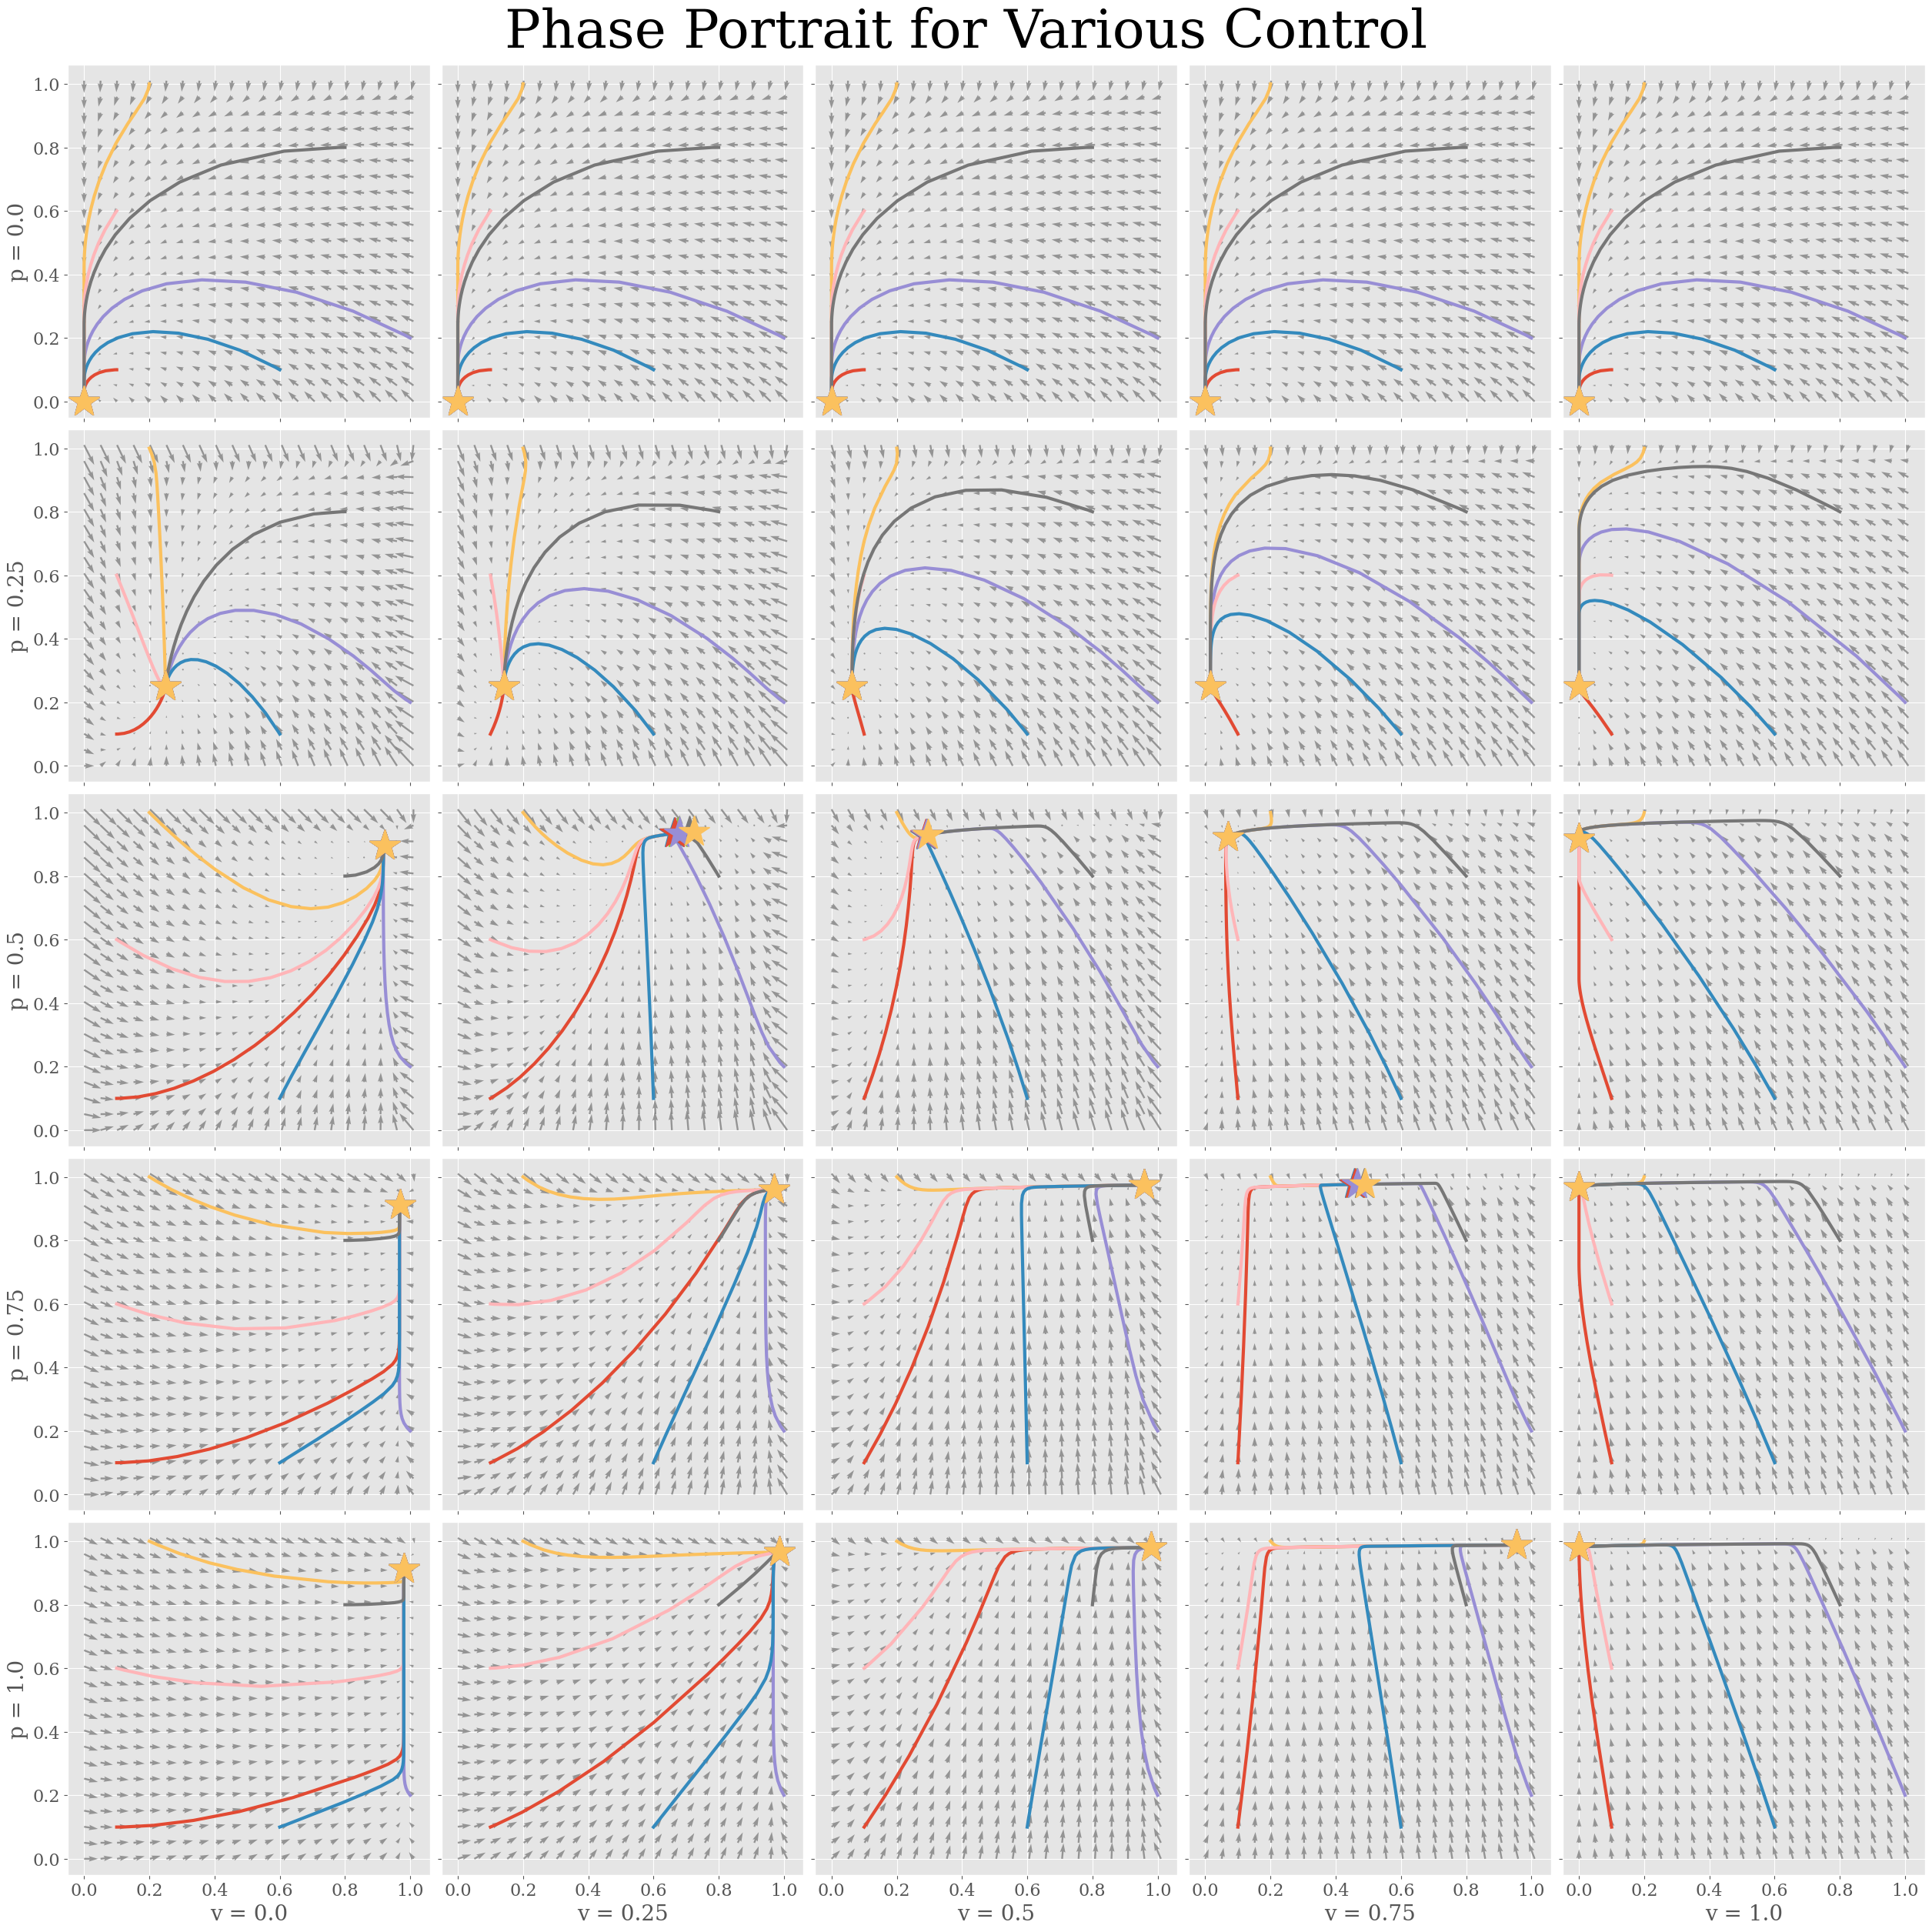

In [110]:
fig_scale = 5
figsize = (int(fig_scale*len(p_vals)), int(fig_scale*len(v_vals)))

fig, axes = plt.subplots(len(p_vals), len(v_vals), figsize = figsize, constrained_layout = True,sharex=True, sharey=True)

for i, pi in enumerate(tqdm(p_vals)):
    for j, vj in enumerate(v_vals):
        ax = axes[i,j]
        U = np.zeros_like(X1)
        V = np.zeros_like(X2)

        for inner_i in range(X1.shape[0]):
            for inner_j in range(X1.shape[1]):
                x = np.array([X1[inner_i,inner_j], X2[inner_i,inner_j]])
                dxdt = two_tank_system(0, x, (pi, vj))
                U[inner_i,inner_j] = dxdt[0]
                V[inner_i,inner_j] = dxdt[1]  
        # ax.quiver(X1, X2, U, V, angles='xy', scale=1.7, color='grey', alpha=1)
        ax.quiver(
            X1, X2, U, V,
            angles='xy',
            # scale=0.05,         # smaller → longer arrows
            scale_units='xy',   # interpret scale in data coords
            width=0.005,        # arrow thickness
            color='grey',
            alpha=0.8
        )
        # try:
        #     sol = root(lambda X: two_tank_system(0, X, (pi, vj)), prev_eq)
        #     print(sol.success, sol.x)
        #     # prev_eq = sol.x if sol.success else prev_eq
        #     ax.plot(sol.x[0], sol.x[1], label='equilibrium',zorder=2,marker="s")
        # except:
        #     pass
            
        for x0_i in x_inits:
            sol_ivp = solve_ivp(lambda t,y: two_tank_system(t, y, (pi, vj)), t_span, x0_i, rtol=1e-6, atol=1e-9)
            ax.plot(sol_ivp.y[0], sol_ivp.y[1], '-', lw=3,zorder=1)
            x_last = sol_ivp.y[:,-1]
            ax.plot(x_last[0],x_last[1], marker='*',markersize=30)

        
        if j == 0:
            ax.set_ylabel(f"p = {pi}",size=20)
        
        if i == len(v_vals) -1:
            ax.set_xlabel(f"v = {vj}",size=20)
        ax.tick_params(axis='both', which='major', labelsize=16)  # major ticks

plt.suptitle("Phase Portrait for Various Control",size=50)
plt.show()



In [98]:
sol_ivp.y[:,-1], sol_ivp.y[-1]

(array([-1.06285442e-08,  9.80394292e-01]),
 array([0.8       , 0.8033498 , 0.83658852, 0.88017497, 0.92173513,
        0.95889954, 0.97211275, 0.98016482, 0.98504156, 0.9881224 ,
        0.99001917, 0.99111502, 0.99169018, 0.99194751, 0.99202434,
        0.99200468, 0.99193249, 0.99182397, 0.99167753, 0.99149008,
        0.99128798, 0.99109627, 0.99091258, 0.99072277, 0.99052298,
        0.99031964, 0.99011648, 0.98991149, 0.98970224, 0.98948899,
        0.98927282, 0.98905386, 0.98883164, 0.98860599, 0.98837705,
        0.98814488, 0.98790946, 0.98767077, 0.98742887, 0.9871838 ,
        0.98693564, 0.98668448, 0.98643042, 0.9861736 , 0.9859142 ,
        0.98565242, 0.98538849, 0.9851227 , 0.98485538, 0.98458689,
        0.9843177 , 0.98404828, 0.98377923, 0.9835112 , 0.98324497,
        0.98298142, 0.98272165, 0.98246696, 0.98221901, 0.98198   ,
        0.9817529 , 0.98156497, 0.98139747, 0.9812515 , 0.98112608,
        0.98101924, 0.98092873, 0.98085248, 0.98078871, 0.98073596,
    